1) Importing API key. Create a separate .py file to store your API keys and password

In [1]:
from google.colab import files

uploaded = files.upload()


Saving reddit_api.py to reddit_api.py


In [3]:
import sys
sys.path.append('/content/')
import reddit_api

id = reddit_api.id
secret = reddit_api.secret
user = reddit_api.user


2) Install and Import the other relevant Libraries

In [5]:
!pip install nest_asyncio asyncpraw emoji tweetnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
#for scraping subreddit
from typing import List, Tuple
import nest_asyncio
import asyncio
import asyncpraw
from asyncpraw.models import MoreComments

from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import re

import tweetnlp


3) Scraping the relevant r/singapore subreddit threads

In [7]:
tkl_singapore = ['https://www.reddit.com/r/singapore/comments/15y8hle/tan_kin_lian_on_pretty_girls_controversy_maybe/',
           'https://www.reddit.com/r/singapore/comments/15ybahz/any_good_sides_to_tan_kin_lian/',
           'https://www.reddit.com/r/singapore/comments/15yt7fq/tan_kin_lians_pretty_girls_posts_ignite_debate/',
           'https://www.reddit.com/r/singapore/comments/15y2l58/pe_2023_tan_kin_lian_says_sorry_to_women/',
           'https://www.reddit.com/r/singapore/comments/15xrbiy/tan_kin_lian_rejects_awares_concerns_he/',
           'https://www.reddit.com/r/singapore/comments/15xwg7z/i_want_to_give_people_of_spore_a_chance_for_truly/',
           'https://www.reddit.com/r/singapore/comments/15xqltm/presidential_hopeful_tan_kin_lian_accuses_various/',
           'https://www.reddit.com/r/singapore/comments/15v8ztk/tan_kin_lian_says_he_respects_ng_kok_song_but/',
           'https://www.reddit.com/r/singapore/comments/15v6iil/tan_kin_lian_says_he_will_channel_public_feedback/',
           'https://www.reddit.com/r/singapore/comments/15uflz5/i_dont_want_to_be_arrogant_im_somewhat_confident/']

In [8]:
#define function to scrape reddit submissions
async def scrape(urls: List[str]) -> Tuple[List[str],List[str]]:
  reddit = asyncpraw.Reddit(client_id=id,            # your client id
                               client_secret=secret, # your client secret
                               user_agent=user)      # your user agent

  comments_list = []
  threads = []
  for link in urls:
    submission = await reddit.submission(url=link)
    comments = await submission.comments()
    await comments.replace_more(limit=None)
    all_comments = await comments.list()
    for comment in all_comments:
      comments_list.append(comment.body)
      threads.append(link)

  return comments_list, threads

nest_asyncio.apply()

singapore_comments, singapore_threads = asyncio.run(scrape(tkl_singapore))

In [10]:
#view the first 20 elements
singapore_comments[:10]

['he is truly independent for sure. dont think he is vetting his comms with anyone',
 'This is a very strange hill to die on. Or a very strange hole to keep digging in.',
 'He doubling down for real.',
 'earlier: sorry if you are offended\n\nnow: sorry if you are offended because you are not pretty\n\n🤡',
 '"The girls themselves were never offended" is the "No migrant worker has demanded an apology", cheekopek edition.\n\nYou know, I always thought his facebook profile was a troll profile because no one could possibly be that out of touch with reality... right? Right?!? Turns out I was wrong.',
 'Funnily enough, it brings me back to when Trump was elected POTUS. After someone like Obama, we laughed thinking that a womanizing, sexist guy who gave comments like “grab them by the pussy!” could stand for election to the highest position in the country, but he won.\n\nI see similarities here, with one party totally incredulous at his nomination, and another totally supportive and overlookin

4) Preprocess the text

In [11]:
def preprocess_text(text: str) -> str:
  processed = text.lower().replace("\n",' ').replace("\r",'').replace("\t",'')
  processed = re.sub(r"[!?:\-.,\"]", "", processed)
  processed = re.sub(r"https://[\w\S]+", "",processed)
  return processed

In [12]:
  sample = preprocess_text(singapore_comments[4])
  print(sample)

the girls themselves were never offended is the no migrant worker has demanded an apology cheekopek edition  you know i always thought his facebook profile was a troll profile because no one could possibly be that out of touch with reality right right turns out i was wrong


5) Conduct Sentiment Analysis using TweetNLP library

In [13]:
model2 = tweetnlp.load_model('emotion')

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7ff9d5eb63b0>


In [14]:
emotions = []

for comment in tqdm(singapore_comments):
  processed_text = preprocess_text(comment)
  emotion_label = model2.emotion(processed_text)['label']
  emotions.append(emotion_label)



100%|██████████| 1364/1364 [04:41<00:00,  4.85it/s]


6) Visualize results using Matplotlib/Seaborn

In [15]:
singapore_sub_df = pd.DataFrame({'emotions':emotions,
                                 'thread':singapore_threads
                                 })

singapore_sub_df

,emotions,thread
0,anticipation,https://www.reddit.com/r/singapore/comments/15...
1,fear,https://www.reddit.com/r/singapore/comments/15...
2,joy,https://www.reddit.com/r/singapore/comments/15...
3,anger,https://www.reddit.com/r/singapore/comments/15...
4,anger,https://www.reddit.com/r/singapore/comments/15...
...,...,...
1359,joy,https://www.reddit.com/r/singapore/comments/15...
1360,anticipation,https://www.reddit.com/r/singapore/comments/15...
1361,anticipation,https://www.reddit.com/r/singapore/comments/15...
1362,anticipation,https://www.reddit.com/r/singapore/comments/15...


In [16]:
#create a new column to map the url to a shortform for the article to improve readability:
threads_mapping = {'https://www.reddit.com/r/singapore/comments/15y8hle/tan_kin_lian_on_pretty_girls_controversy_maybe/':'pretty girls contro',
           'https://www.reddit.com/r/singapore/comments/15ybahz/any_good_sides_to_tan_kin_lian/':'any good sides?',
           'https://www.reddit.com/r/singapore/comments/15yt7fq/tan_kin_lians_pretty_girls_posts_ignite_debate/':'ignite debate',
           'https://www.reddit.com/r/singapore/comments/15y2l58/pe_2023_tan_kin_lian_says_sorry_to_women/':'says sorry women',
           'https://www.reddit.com/r/singapore/comments/15xrbiy/tan_kin_lian_rejects_awares_concerns_he/':'reject AWARE concern',
           'https://www.reddit.com/r/singapore/comments/15xwg7z/i_want_to_give_people_of_spore_a_chance_for_truly/':'give SG chance',
           'https://www.reddit.com/r/singapore/comments/15xqltm/presidential_hopeful_tan_kin_lian_accuses_various/':'accuse smear campaign',
           'https://www.reddit.com/r/singapore/comments/15v8ztk/tan_kin_lian_says_he_respects_ng_kok_song_but/':'respect NKS',
           'https://www.reddit.com/r/singapore/comments/15v6iil/tan_kin_lian_says_he_will_channel_public_feedback/':'channel public feedbk',
           'https://www.reddit.com/r/singapore/comments/15uflz5/i_dont_want_to_be_arrogant_im_somewhat_confident/':'confident win election'
           }

def url_mapped(url: str) -> str:
  return threads_mapping.get(url)

singapore_sub_df['article'] = singapore_sub_df['thread'].apply(url_mapped)
singapore_sub_df.head()

,emotions,thread,article
0,anticipation,https://www.reddit.com/r/singapore/comments/15...,pretty girls contro
1,fear,https://www.reddit.com/r/singapore/comments/15...,pretty girls contro
2,joy,https://www.reddit.com/r/singapore/comments/15...,pretty girls contro
3,anger,https://www.reddit.com/r/singapore/comments/15...,pretty girls contro
4,anger,https://www.reddit.com/r/singapore/comments/15...,pretty girls contro


In [17]:
#Tabulating overall sentiments
overall_sentiments = singapore_sub_df.groupby(['emotions']).size().reset_index(name='count')
overall_sentiments

,emotions,count
0,anger,477
1,anticipation,242
2,disgust,178
3,fear,26
4,joy,227
5,optimism,94
6,sadness,116
7,surprise,4


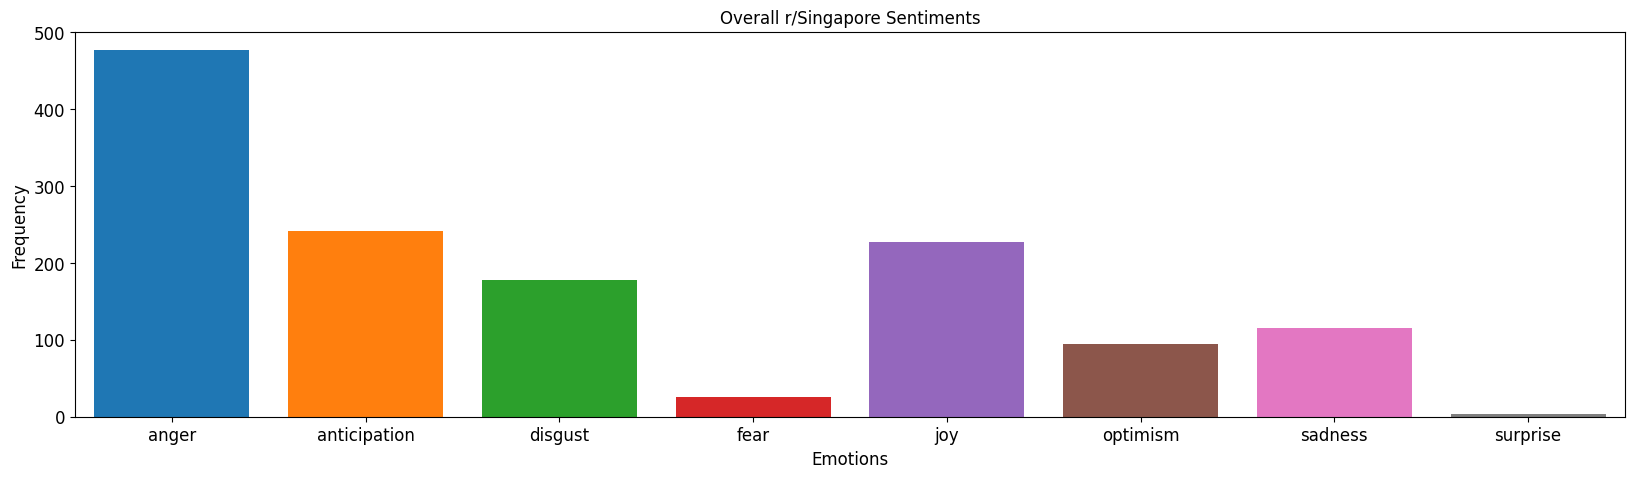

In [18]:
#Visualize overall sentiments
ax = sns.barplot(x='emotions', y='count', data=overall_sentiments, saturation=1, errorbar=None)
ax.set_title('Overall r/Singapore Sentiments')
plt.gcf().set_size_inches(20,5)
plt.tick_params(labelsize=12)
plt.xlabel('Emotions',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.savefig('overall_sentiments.png',bbox_inches='tight')
plt.show()

In [19]:
#Tabulating sentiments grouped by reddit thread
singapore_sub_df_grouped = singapore_sub_df.groupby(['article', 'emotions']).size().reset_index(name='count')
singapore_sub_df_grouped['percentage'] = singapore_sub_df_grouped.groupby('article')['count'].transform(lambda x: x / x.sum() * 100)
print(singapore_sub_df_grouped)

                  article      emotions  count  percentage
0   accuse smear campaign         anger     70   45.454545
1   accuse smear campaign  anticipation     18   11.688312
2   accuse smear campaign       disgust     24   15.584416
3   accuse smear campaign          fear      4    2.597403
4   accuse smear campaign           joy     14    9.090909
..                    ...           ...    ...         ...
67       says sorry women       disgust     20   14.814815
68       says sorry women          fear      2    1.481481
69       says sorry women           joy     20   14.814815
70       says sorry women      optimism      1    0.740741
71       says sorry women       sadness     11    8.148148

[72 rows x 4 columns]


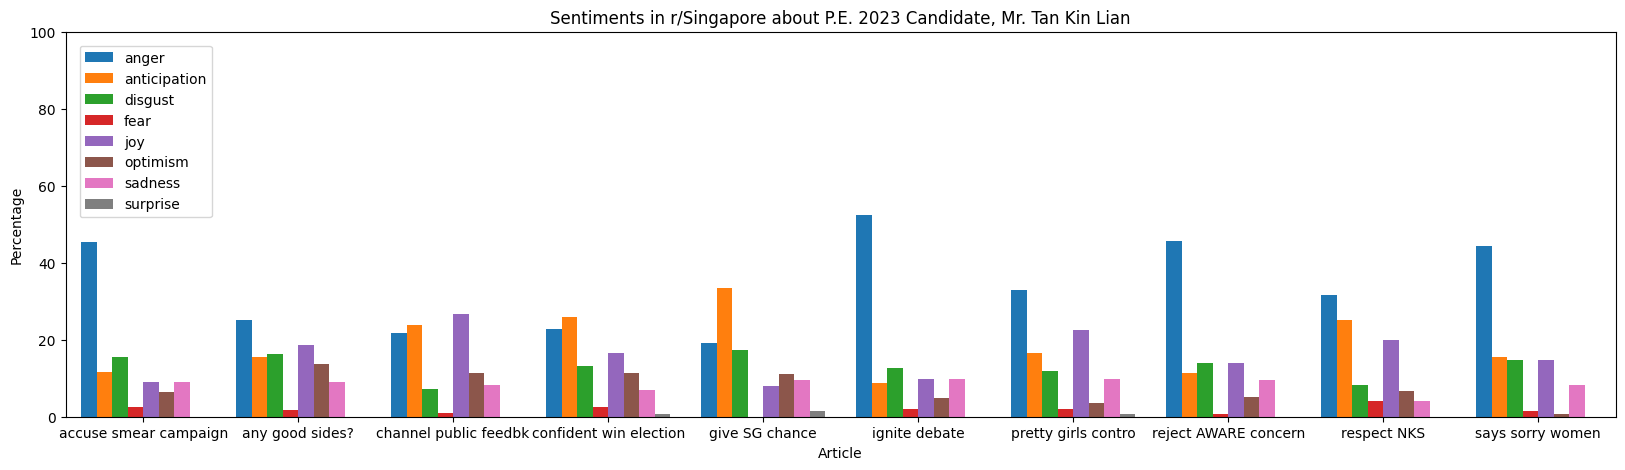

In [20]:
#Visualise sentiments grouped by reddit thread
ax = sns.barplot(x='article', y='percentage', hue='emotions', data=singapore_sub_df_grouped, saturation=1)
ax.set_title('Sentiments in r/Singapore about P.E. 2023 Candidate, Mr. Tan Kin Lian')
plt.gcf().set_size_inches(20,5)
plt.legend(loc='upper left', borderaxespad=1)
plt.ylabel('Percentage')
plt.xlabel('Article')
plt.ylim(0, 100)
plt.savefig('article_sentiments.png',bbox_inches='tight')
plt.show()